In [1]:
import os
import sys
import scipy.io
import scipy.misc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from pretrained_model_utils import *

%matplotlib inline

### Content Image

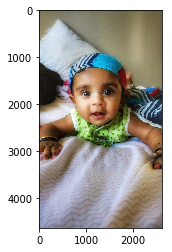

In [2]:
content_image = scipy.misc.imread('images/content_2.jpeg')
plt.imshow(content_image)

In [3]:
print (content_image.shape)


(4640, 2610, 3)


## Style image

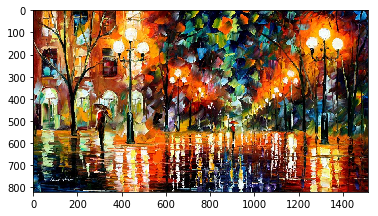

In [4]:
style_image = scipy.misc.imread('images/impression_1.jpeg')
plt.imshow(style_image)

In [5]:
print (style_image.shape)

(821, 1514, 3)


In [6]:
def compute_content_loss(act_content, act_gen):
    m,n_H,n_W,n_C = act_gen.get_shape().as_list()
    
    unrolled_act_content = tf.reshape(act_content,[n_H*n_W,tf.transpose(n_C)])
    unrolled_act_gen = tf.reshape(act_gen,[n_H*n_W,tf.transpose(n_C)])
    
    content_loss = tf.multiply(1/(4*n_H*n_W*n_C),tf.reduce_sum(tf.square(unrolled_act_content - unrolled_act_gen)))
    
    return content_loss
    

In [7]:
def compute_gram(act_img):
    gram_matrix = tf.matmul(act_img,tf.transpose(act_img))
    return gram_matrix

In [8]:
tf.reset_default_graph()

with tf.Session() as test_sess:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = compute_gram(A)
    print (GA.eval())

[[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [9]:
def compute_style_loss(act_style, act_gen):
    m,n_H,n_W,n_C = act_gen.get_shape().as_list()
#     unrolled_act_style = tf.reshape(act_style,[tf.transpose(n_C),n_H*n_W])
#     unrolled_act_gen = tf.reshape(act_gen,[tf.transpose(n_C),n_H*n_W])

    unrolled_act_style = tf.reshape(tf.transpose(act_style),shape=[n_C,-1])
    unrolled_act_gen = tf.reshape(tf.transpose(act_gen),shape=[n_C,-1])
    
    #print (unrolled_act_style.shape)
    
    gram_style = compute_gram(unrolled_act_style)
    gram_gen = compute_gram(unrolled_act_gen)
    
    layer_style_loss = tf.multiply(1/(4*(n_C**2)*(n_H*n_W)**2),tf.reduce_sum(tf.square(gram_style-gram_gen)))
    
    return layer_style_loss

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_style_loss(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [11]:
 STYLE_LAYERS = [
    ('conv1_2', 0.2),
    ('conv2_2', 0.2),
    ('conv3_3', 0.2),
    ('conv4_3', 0.2),
    ('conv5_3', 0.2)]


In [12]:
def compute_model_style_loss(model):
    
    style_loss = 0
    
    for layer_name,cost in STYLE_LAYERS:
        layer = model[layer_name]
        act_style_layer = sess.run(layer)
        
        act_gen = layer
        
        style_loss += cost*compute_style_loss(act_style_layer,act_gen)
        
    return style_loss
        

In [13]:
def total_model_loss(content_loss, style_loss,total_var_weight,alpha,beta):
    loss = total_var_weight*(alpha*content_loss+beta*style_loss)
    
    return loss

In [14]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

resize_image('images/content_3.jpeg','content')

resized_content = scipy.misc.imread('images/resized_content.jpg')

content_image = reshape_image(resized_content)

resize_image('images/Self-Portrait.jpg','style_image')

resized_style = scipy.misc.imread('images/resized_style_image.jpg')

style_image = reshape_image(resized_style)

gen_image = get_noise_image(content_image)



In [15]:
vgg_model = load_pretrained_VGG()

sess.run(vgg_model['input'].assign(content_image))

out = vgg_model['conv4_3']

content_activation = sess.run(out)

generated_activation = out

content_loss = compute_content_loss(content_activation,generated_activation)

sess.run(vgg_model['input'].assign(style_image))

style_loss = compute_model_style_loss(vgg_model)

total_loss = total_model_loss(content_loss,style_loss,1,300,5)

(64,)
(64,)
(128,)
(128,)
(256,)
(256,)
(256,)
(256,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


In [16]:
train_step = tf.train.AdamOptimizer(learning_rate=2.0).minimize(total_loss)


In [17]:
def run_model(sess,image,num_iterations=1000):
    
    sess.run(tf.global_variables_initializer())
    
    generated_image = sess.run(vgg_model['input'].assign(image))
    
    #print (generated_image.shape)
    
    for i in range(num_iterations):
        
        sess.run(train_step)
        
        generated_image = sess.run(vgg_model['input'])
        
        #print (generated_image.shape)
        
        #print (generated_image[0])
        
        s_loss, c_loss, t_loss = sess.run([style_loss,content_loss,total_loss])
        
        print ("iteration: "+str(i))
        
        print ("style_loss: "+str(s_loss))
        
        print ("content_loss: "+str(c_loss))

        print ("total_loss: "+str(t_loss))
        
        if i % 20 == 0:
            save_image('images/gen_image_'+str(i)+'.jpg',generated_image)
        
    save_image('images/final_gen_image.jpg',generated_image)
        
    

In [18]:
run_model(sess,gen_image)

iteration: 0
style_loss: 2.68991e+07
content_loss: 9765.59
total_loss: 1.37425e+08
iteration: 1
style_loss: 2.33989e+07
content_loss: 9698.48
total_loss: 1.19904e+08
iteration: 2
style_loss: 1.97846e+07
content_loss: 9708.47
total_loss: 1.01836e+08
iteration: 3
style_loss: 1.66594e+07
content_loss: 9762.78
total_loss: 8.62259e+07
iteration: 4
style_loss: 1.43332e+07
content_loss: 9813.77
total_loss: 7.46103e+07
iteration: 5
style_loss: 1.27126e+07
content_loss: 9838.73
total_loss: 6.65148e+07
iteration: 6
style_loss: 1.15477e+07
content_loss: 9866.4
total_loss: 6.06983e+07
iteration: 7
style_loss: 1.05907e+07
content_loss: 9898.27
total_loss: 5.59232e+07
iteration: 8
style_loss: 9.73218e+06
content_loss: 9917.39
total_loss: 5.16361e+07
iteration: 9
style_loss: 9.0015e+06
content_loss: 9926.75
total_loss: 4.79855e+07
iteration: 10
style_loss: 8.38486e+06
content_loss: 9936.68
total_loss: 4.49053e+07
iteration: 11
style_loss: 7.81701e+06
content_loss: 9953.39
total_loss: 4.20711e+07
iter